In [2]:
import numpy as np 
from keras.datasets import mnist
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(-1, 784)

x_test = x_test.reshape(-1, 784)

In [4]:
x_train, x_test = x_train.astype(np.float_), x_test.astype(np.float_)

x_train /= 255
x_test /= 255

print(x_train.max())
print(x_test.min())

1.0
0.0


In [5]:
onv = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

one_hot_y_train = onv.fit_transform(y_train[:, np.newaxis])
one_hot_y_test = onv.fit_transform(y_test[:, np.newaxis])

print(one_hot_y_test.shape)
print(one_hot_y_train.shape)

(10000, 10)
(60000, 10)


In [6]:
x_train, x_val, y_train, y_val = train_test_split(x_train, one_hot_y_train, test_size=0.2)

print(x_train.shape)
print(x_val.shape)

(48000, 784)
(12000, 784)


In [7]:
class FC:
    """
    Number of nodes Fully connected layer from n_nodes1 to n_nodes2
    Parameters
    ----------
    n_nodes1 : int
      Number of nodes in the previous layer
    n_nodes2 : int
      Number of nodes in the later layer
    initializer: instance of initialization method
    optimizer: instance of optimization method
    """
    
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        self.weights = initializer.W(n_nodes1, n_nodes2)
        self.bias = initializer.B(n_nodes2)
        

        
    
    def forward(self, X):
        """
        forward
        Parameters
        ----------
        X : The following forms of ndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : The following forms of ndarray, shape (batch_size, n_nodes2)
            output
        """        
        self.Z = X
        A = X @ self.weights + self.bias
        
        return A
    
    def backward(self, dA):
        """
        Backward
        Parameters
        ----------
        dA : The following forms of ndarray, shape (batch_size, n_nodes2)
            Gradient flowing from behind
        Returns
        ----------
        dZ : The following forms of ndarray, shape (batch_size, n_nodes1)
            Gradient to flow forward
        """
        
        # update
        self.dB = np.sum(dA, axis=0)
        self.dW = self.Z.T @ dA 
        self.dZ = dA @ self.weights.T
        
        self.optimizer.update(self)
        
        return self.dZ


In [8]:
class SimpleInitializer:
    """
    Simple initialization with Gaussian distribution
    Parameters
    ----------
    sigma : float
      Standard deviation of Gaussian distribution
    """
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        """
        Weight initialization
        Parameters
        ----------
        n_nodes1 : int
          Number of nodes in the previous layer
        n_nodes2 : int
          Number of nodes in the later layer

        Returns
        ----------
        W :
        """
        w = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        
        return w
    
    def B(self, n_nodes2):
        """
        Bias initialization
        Parameters
        ----------
        n_nodes2 : int
          Number of nodes in the later layer

        Returns
        ----------
        B :
        """
        B = self.sigma * np.random.randn(n_nodes2)
        return B

In [9]:
class SGD:
    """
    Stochastic gradient descent
    Parameters
    ----------
    lr : Learning rate
    """
    def __init__(self, lr):
        self.lr = lr
    def update(self, layer):
        """
        The weight or bias of a certain layer
        Parameters
        ----------
        layer : Instance of the layer before update
        """

        layer.weights -= self.lr * layer.dW
        layer.bias -= self.lr * layer.dB

In [10]:
class Relu:
    def __init__(self) -> None:
        pass

    def forward(self, X):
        return np.maximum(np.zeros(X.shape), X)
    
    def backward(self, X):
        a = X > 0
        return a * 1


class Softmax():
        def __init__(self) -> None:
            pass


        def forward(self, a):
            numerator = np.exp(a)
            return numerator / np.sum(np.exp(a), axis=1, keepdims=True)
        
    

### Problem 6

In [11]:
class XavierInitializer:
    def __init__(self, n):
        """
        n: Length of dataset
        """
        self.sigma = 1/(n**0.5)
        
    
    def W(self, n_nodes1, n_nodes2):
        return np.random.normal(0, self.sigma, (n_nodes1, n_nodes2))
    
    def B(self, n_nodes):
        return np.random.normal(0, self.sigma, (n_nodes))
    

class HeInitializer:
    def __init__(self, n):
        """
        n: Length of dataset
        """
        
        self.sigma = (2 / n) ** 0.5
        
    
    def W(self, n_nodes1, n_nodes2):
        return np.random.normal(0, self.sigma, (n_nodes1, n_nodes2))
    
    def B(self, n_nodes):
        return np.random.normal(0, self.sigma, (n_nodes))
    


### Problem 7

In [12]:
class AdaGrab:
    def __init__(self, lr):
        self.lr = lr 
        self.ssg = 0

    def update(self, layer):
        
        self.ssg += np.sum(layer.weights ** 2)  
        adaptive_lr = self.lr / np.sqrt(self.ssg + 1e-8)
        layer.weights -= (self.lr - adaptive_lr) * (layer.weights)
        layer.bias -= (self.lr - adaptive_lr) * layer.bias

        
    

In [13]:
class GetMiniBatch:
    """
Iterator to get a mini-batch

    Parameters
    ----------
    X : The following forms of ndarray, shape (n_samples, n_features)
      Training data
    y : The following form of ndarray, shape (n_samples, 1)
      Correct answer value
    batch_size : int
      Batch size
    seed : int
      NumPy random seed
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int_)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [14]:
class ScratchDeepNeuralNetrowkClassifier():
    """
    Simple three-layer neural network classifier

    Parameters
    ----------

    Attributes
    ----------
    """

    def __init__(self, lr,verbose = True, epoch = 10, initializer="simple", optimizer="stochastic"):
        self.verbose = verbose
        self.lr = lr
        self.epoch = epoch
        self.init = initializer
        self.opti = optimizer
        

    def fit(self, X, y, X_val=None, y_val=None):
        """
        Learn a neural network classifier.

        Parameters
        ----------
        X : The following forms of ndarray, shape (n_samples, n_features)
            Features of training data
        y : The following form of ndarray, shape (n_samples,)
            Correct answer value of training data
        X_val : The following forms of ndarray, shape (n_samples, n_features)
            Features of verification data
        y_val : The following form of ndarray, shape (n_samples,)
            Correct value of verification data
        """
        # model hyperparameter
        n_features = X.shape[1]
        n_nodes1 = 400
        n_nodes2 = 200
        output = 10
        self.batch_size = 20
        size = X.shape[0]
        sigma = 0.01 if self.init == "simple" else size
        

        # intializing initializer, optimizer, and layers of networks
        initializers = {
            "xavier": XavierInitializer,
            "he": HeInitializer,
            "simple": SimpleInitializer
        }

        optimizers = {
            "stochastic": SGD, 
            "AdaGrad": AdaGrab
        }

        initializer = initializers[self.init]
        optimizer = optimizers[self.opti](self.lr)
        
        sigma = 0.01 if self.init == "simple" else n_features
        self.FC1 = FC(n_features, n_nodes1, initializer(sigma), optimizer)

        sigma = 0.01 if self.init == "simple" else n_nodes1
        self.FC2 = FC(n_nodes1, n_nodes2, initializer(sigma), optimizer)

        sigma = 0.01 if self.init == "simple" else n_nodes2
        self.FC3 = FC(n_nodes2, output, initializer(sigma), optimizer)

        # Initialising activation functions
        relu = Relu()
        softmax = Softmax()

        # initializing losses
        self.loss_train = np.array([])
        self.loss_val = np.array([])
        
        for _ in range(self.epoch):
            get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size)

            for mini_x_train, mini_y_train in get_mini_batch:
                # forward propagation
                #first layer
                self.A1 = self.FC1.forward(mini_x_train)
                self.Z1 = relu.forward(self.A1)
                # second layer
                self.A2 = self.FC2.forward(self.Z1)
                self.Z2 = relu.forward(self.A2)
                #third layer
                self.A3 = self.FC3.forward(self.Z2)
                self.Z3 = softmax.forward(self.A3)

                # backward propagation

                # third layer
                dA3 = (self.Z3 - mini_y_train) / self.batch_size
                dZ2 = self.FC3.backward(dA3)

                # second layer
                dA2 = dZ2 * relu.backward(self.A2)
                dZ1 = self.FC2.backward(dA2)

                # first layer
                dA1 = dZ1 * relu.backward(self.A1)
                dZ0 = self.FC1.backward(dA1)

                
            #first layer
            self.A1 = self.FC1.forward(X)
            self.Z1 = relu.forward(self.A1)
            # second layer
            self.A2 = self.FC2.forward(self.Z1)
            self.Z2 = relu.forward(self.A2)
            #third layer
            self.A3 = self.FC3.forward(self.Z2)
            self.Z3 = softmax.forward(self.A3)
            
            self.loss_train = np.append(self.loss_train, self.cross_entropy(y))

            if X_val is not None:
                self.A1 = self.FC1.forward(X_val)
                self.Z1 = relu.forward(self.A1)
                # second layer
                self.A2 = self.FC2.forward(self.Z1)
                self.Z2 = relu.forward(self.A2)
                #third layer
                self.A3 = self.FC3.forward(self.Z2)
                self.Z3 = softmax.forward(self.A3)
                self.loss_val = np.append(self.loss_val, self.cross_entropy(y_val))
               
            if self.verbose:
                if X_val is not None:
                    print(f"{_}: {self.loss_val}")
                else:
                    print(f"{_}: {self.loss_train}")
        return self
                               


    def predict(self, X):
        """
        Estimate using a neural network classifier.

        Parameters
        ----------
        X : The following forms of ndarray, shape (n_samples, n_features)
            sample

        Returns
        -------
            The following form of ndarray, shape (n_samples, 1)
            Estimated result
        """
        relu = Relu()
        softmax = Softmax()

        self.A1 = self.FC1.forward(X)
        self.Z1 = relu.forward(self.A1)
        # second layer
        self.A2 = self.FC2.forward(self.Z1)
        self.Z2 = relu.forward(self.A2)
        #third layer
        self.A3 = self.FC3.forward(self.Z2)
        self.Z3 = softmax.forward(self.A3)
        
        return np.argmax(self.Z3, axis=1)
    
    def cross_entropy(self, y):
        loss = - np.sum(y * np.log(self.Z3 + 1e-7))
        return loss/len(y)
    

In [48]:
model = ScratchDeepNeuralNetrowkClassifier(1e-3, True, 30).fit(x_train, y_train, X_val=x_val, y_val=y_val)

0: [2.30080817]
1: [2.30080817 2.29872886]
2: [2.30080817 2.29872886 2.29555765]
3: [2.30080817 2.29872886 2.29555765 2.28932044]
4: [2.30080817 2.29872886 2.29555765 2.28932044 2.27345984]
5: [2.30080817 2.29872886 2.29555765 2.28932044 2.27345984 2.22002503]
6: [2.30080817 2.29872886 2.29555765 2.28932044 2.27345984 2.22002503
 2.06563943]
7: [2.30080817 2.29872886 2.29555765 2.28932044 2.27345984 2.22002503
 2.06563943 1.80335053]
8: [2.30080817 2.29872886 2.29555765 2.28932044 2.27345984 2.22002503
 2.06563943 1.80335053 1.44874224]
9: [2.30080817 2.29872886 2.29555765 2.28932044 2.27345984 2.22002503
 2.06563943 1.80335053 1.44874224 1.11007382]
10: [2.30080817 2.29872886 2.29555765 2.28932044 2.27345984 2.22002503
 2.06563943 1.80335053 1.44874224 1.11007382 0.892973  ]
11: [2.30080817 2.29872886 2.29555765 2.28932044 2.27345984 2.22002503
 2.06563943 1.80335053 1.44874224 1.11007382 0.892973   0.77098517]
12: [2.30080817 2.29872886 2.29555765 2.28932044 2.27345984 2.22002503
 2.

### Graph of Loss 

Text(0.5, 1.0, 'Loss vs epoch')

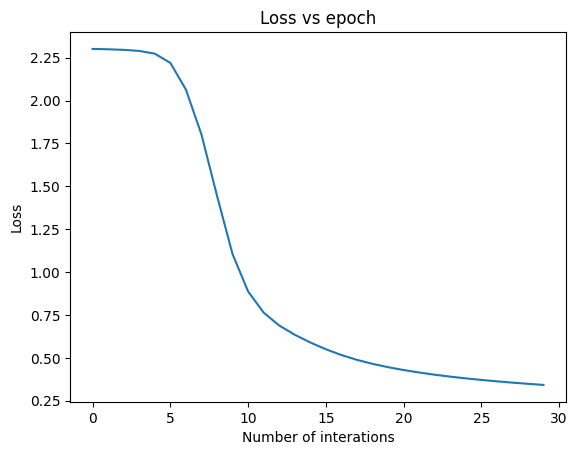

In [49]:
plt.plot(model.loss_train)
plt.xlabel("Number of interations")
plt.ylabel("Loss")
plt.title("Loss vs epoch")


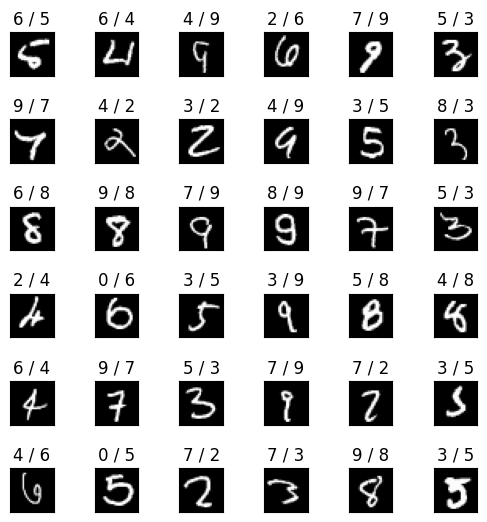

In [50]:

y_pred = model.predict(x_test)
y_valu = y_test

num = 36 # How many to display
true_false = y_pred==y_valu
false_list = np.where(true_false==False)[0].astype(np.int_)

if false_list.shape[0] < num:
    num = false_list.shape[0]
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=0.8,  bottom=0, top=0.8, hspace=1, wspace=0.5)
for i in range(num):
    ax = fig.add_subplot(6, 6, i + 1, xticks=[], yticks=[])
    ax.set_title("{} / {}".format(y_pred[false_list[i]],y_valu[false_list[i]]))
    ax.imshow(x_test.reshape(-1,28,28)[false_list[i]], cmap='gray')


In [54]:
print(f" Accuracy score: {accuracy_score(y_test, y_pred)}")


 Accuracy score: 0.9015


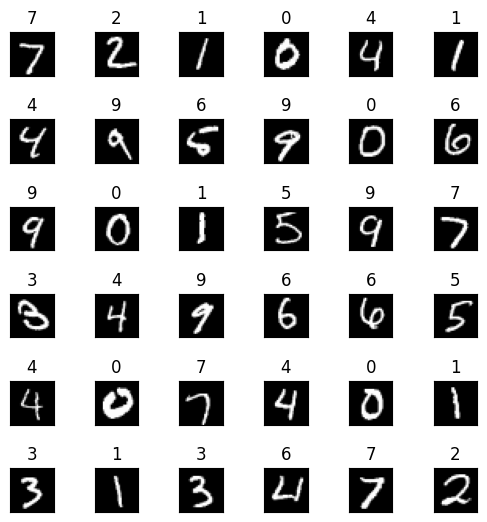

In [34]:

fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=0.8,  bottom=0, top=0.8, hspace=1, wspace=0.5)
for i in range(num):
    ax = fig.add_subplot(6, 6, i + 1, xticks=[], yticks=[])
    ax.set_title(y_pred[i])
    ax.imshow(x_test.reshape(-1,28,28)[i], cmap='gray')

### He initializer and Stochastic optimizer

In [15]:
model1 = ScratchDeepNeuralNetrowkClassifier(1e-3, True, epoch=30, initializer="he", optimizer="stochastic").fit(x_train, y_train, x_val, y_val)

pred = model1.predict(x_test)


0: [0.76782479]
1: [0.76782479 0.50344099]
2: [0.76782479 0.50344099 0.41718693]
3: [0.76782479 0.50344099 0.41718693 0.37319453]
4: [0.76782479 0.50344099 0.41718693 0.37319453 0.34539714]
5: [0.76782479 0.50344099 0.41718693 0.37319453 0.34539714 0.3254584 ]
6: [0.76782479 0.50344099 0.41718693 0.37319453 0.34539714 0.3254584
 0.30998326]
7: [0.76782479 0.50344099 0.41718693 0.37319453 0.34539714 0.3254584
 0.30998326 0.29726784]
8: [0.76782479 0.50344099 0.41718693 0.37319453 0.34539714 0.3254584
 0.30998326 0.29726784 0.28644635]
9: [0.76782479 0.50344099 0.41718693 0.37319453 0.34539714 0.3254584
 0.30998326 0.29726784 0.28644635 0.27699188]
10: [0.76782479 0.50344099 0.41718693 0.37319453 0.34539714 0.3254584
 0.30998326 0.29726784 0.28644635 0.27699188 0.26850264]
11: [0.76782479 0.50344099 0.41718693 0.37319453 0.34539714 0.3254584
 0.30998326 0.29726784 0.28644635 0.27699188 0.26850264 0.26085594]
12: [0.76782479 0.50344099 0.41718693 0.37319453 0.34539714 0.3254584
 0.3099832

In [16]:
print("Accuracy score")
print(accuracy_score(y_test, pred))

Accuracy score
0.9533


Text(0.5, 1.0, 'Loss vs epoch')

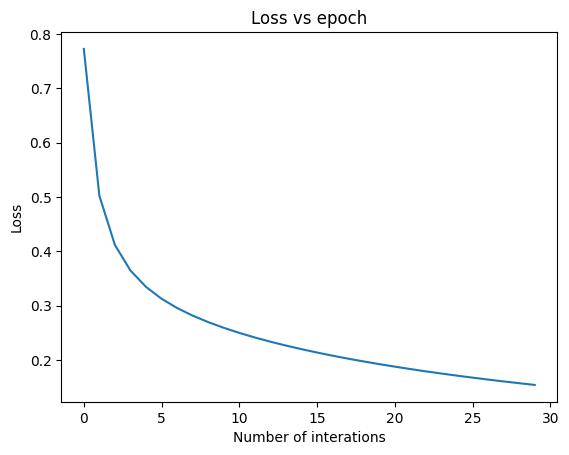

In [17]:
plt.plot(model1.loss_train)
plt.xlabel("Number of interations")
plt.ylabel("Loss")
plt.title("Loss vs epoch")

### Xavier initializer and Stochastic optimizer

In [36]:
model2 = ScratchDeepNeuralNetrowkClassifier(1e-3, True, epoch=30, initializer= "xavier", optimizer="stochastic").fit(x_train, y_train, x_val, y_val)




0: [1.30728957]
1: [1.30728957 0.69197599]
2: [1.30728957 0.69197599 0.51646626]
3: [1.30728957 0.69197599 0.51646626 0.44256991]
4: [1.30728957 0.69197599 0.51646626 0.44256991 0.40188817]
5: [1.30728957 0.69197599 0.51646626 0.44256991 0.40188817 0.37559511]
6: [1.30728957 0.69197599 0.51646626 0.44256991 0.40188817 0.37559511
 0.35665059]
7: [1.30728957 0.69197599 0.51646626 0.44256991 0.40188817 0.37559511
 0.35665059 0.34197229]
8: [1.30728957 0.69197599 0.51646626 0.44256991 0.40188817 0.37559511
 0.35665059 0.34197229 0.32997059]
9: [1.30728957 0.69197599 0.51646626 0.44256991 0.40188817 0.37559511
 0.35665059 0.34197229 0.32997059 0.31975759]
10: [1.30728957 0.69197599 0.51646626 0.44256991 0.40188817 0.37559511
 0.35665059 0.34197229 0.32997059 0.31975759 0.3108548 ]
11: [1.30728957 0.69197599 0.51646626 0.44256991 0.40188817 0.37559511
 0.35665059 0.34197229 0.32997059 0.31975759 0.3108548  0.30288154]
12: [1.30728957 0.69197599 0.51646626 0.44256991 0.40188817 0.37559511
 0.

In [40]:
pred = model2.predict(x_test)
print("Accuracy score")
print(accuracy_score(y_test, pred))

Accuracy score
0.9424


Text(0.5, 1.0, 'Loss vs epoch')

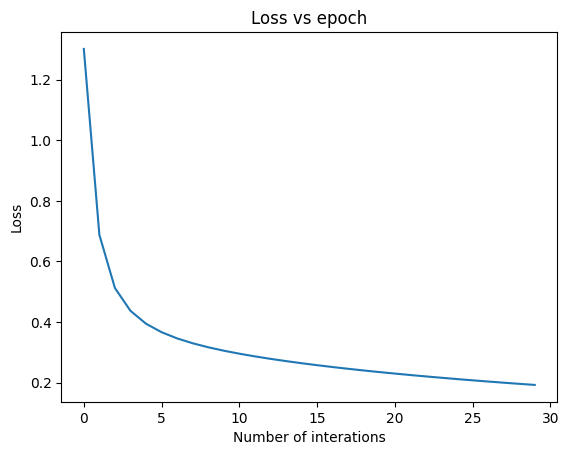

In [38]:
plt.plot(model2.loss_train)
plt.xlabel("Number of interations")
plt.ylabel("Loss")
plt.title("Loss vs epoch")